#  Microstructural brain correlates of inter-individual differences in respiratory interoception 

## Notebook for analysis of behavioural data 

### Set up environment

In [1]:
# Use neurosci environment
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm, pearsonr, spearmanr
import math
from statsmodels.stats.multitest import multipletests

data_dir = '/Users/au657961/github/Respiroception_VBQ/data'
figures_dir = '/Users/au657961/github/Respiroception_VBQ/figures/'


Matplotlib created a temporary cache directory at /var/folders/wh/fsqw487n2kz8s4zncj30yj2dk1v6zh/T/matplotlib-wlnb6lhd because the default path (/Users/au657961/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Figure saving options
flag_savefigs = False

# Font type
mpl.rcParams['font.family'] = 'Helvetica'
# Font size: 24, 32
fontsize_axis_ticks = 28
fontsize_axis_labels = 34

axis_thickness = 2

## Load the data

### Load the RRST behavioural data for the full sample

In [14]:
rrst_data_fpath = f'{data_dir}/rrst_behav_data_full.csv'
rrst_data_full = pd.read_csv(rrst_data_fpath)


In [4]:
## Make exclusions based on the interquartile range; Q1-1.5IQR, Q3+1.5IQR
# N = 240
# Calculate Q1, Q3, and IQR for each measure
Q1 = rrst_data_full[['psi_thresh', 'psi_slope', 'psi_acc', 'aROC']].quantile(0.25)
Q3 = rrst_data_full[['psi_thresh', 'psi_slope', 'psi_acc', 'aROC']].quantile(0.75)
IQR = Q3 - Q1

# Define the thresholds for outliers
threshold_low = Q1 - 1.5 * IQR
threshold_high = Q3 + 1.5 * IQR

# Find rows where any measure is an outlier
outliers = ((rrst_data_full[['psi_thresh', 'psi_slope', 'psi_acc', 'aROC']] < threshold_low) | 
            (rrst_data_full[['psi_thresh', 'psi_slope', 'psi_acc', 'aROC']] > threshold_high)).any(axis=1)

# Create a new DataFrame with outliers removed
cleaned_df = rrst_data_full[~outliers]

# Save the cleaned DataFrame
#cleaned_df.to_csv('cleaned_data.csv', index=False)

### Load the RRST behavioural data only for subject included in the VBQ analysis

In [5]:
vbq_data_fpath = f'{data_dir}/rrst_behav_data_vbq_subset.csv'
rrst_data_subset = pd.read_csv(vbq_data_fpath)

## Figures

### Fig 3a - Group psychometric function

thresh_mean 73.66850289834306 
thresh_sd 12.340924747793322 
thresh_min 26.62098924818912 
thresh_max 114.98704656893824
Slope mean:  0.18675909118627446


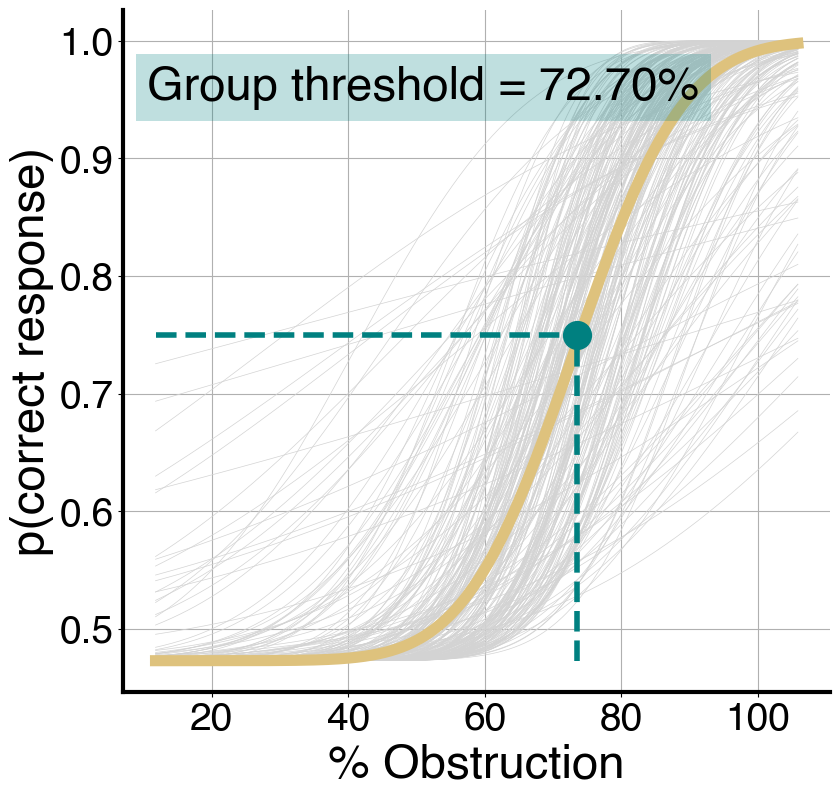

In [20]:
fig_filename = 'rrst_group_pmf.png'

def cumGaussPsychFunc(x, intercept, slope, lower_asymptote):
    return lower_asymptote + (1 - lower_asymptote) * norm.cdf((x * slope + intercept))
    #return lower_asymptote + (1 - 2 * lower_asymptote) * norm.cdf((x - intercept) / slope)

x = np.linspace(2, 18, 1000)

# Create a square plot
plt.figure(figsize=(8.5,8.5))

# Add gridlines
plt.grid(True)
  
for index, row in cleaned_df.iterrows():
    intercept = row['ind_esti_int']
    slope = row['ind_esti_slope']
    lower_asymptote = row['hier_guess']
    y = cumGaussPsychFunc(x, intercept, slope, lower_asymptote)
    # Draw grey functions with thinner lines
    plt.plot(x, y, color='lightgrey', linewidth=0.5)

scale_f = np.divide(100,17)
mean_intercept = cleaned_df['ind_esti_int'].mean()
mean_slope = cleaned_df['ind_esti_slope'].mean()
mean_lower_asymptote = cleaned_df['hier_guess'].mean()
thresh_mean = cleaned_df['real_intercept_ind'].mean()*scale_f
mean_slope_real = cleaned_df['real_slope_ind'].mean()

thresh_sd = (np.std(cleaned_df['real_intercept_ind'])) * scale_f
thresh_min = (np.min(cleaned_df['real_intercept_ind'])) * scale_f
thresh_max = (np.max(cleaned_df['real_intercept_ind'])) * scale_f

print('thresh_mean', thresh_mean, '\nthresh_sd', thresh_sd, '\nthresh_min', thresh_min, '\nthresh_max', thresh_max)
print('Slope mean: ',mean_slope_real)

y_mean = cumGaussPsychFunc(x, mean_intercept, mean_slope, mean_lower_asymptote)

# Draw the mean function with a thicker line
plt.plot(x, y_mean, color=(0.87, 0.76, 0.49), linewidth=8.0)

# Draw lines and point indicating mean threshold
mean_int_x = 12.5
plt.plot([np.min(x), mean_int_x], [0.75, 0.75], color='teal', linestyle='--', linewidth=4)
plt.plot([mean_int_x, mean_int_x], [np.min(y), 0.75], color='teal', linestyle='--', linewidth=4)
plt.scatter(12.5, 0.75, s=400, color='teal', edgecolor='teal', zorder=5) # s defines the size


plt.xlabel('% Obstruction', fontsize=fontsize_axis_labels)
plt.ylabel('p(correct response)', fontsize=fontsize_axis_labels)

plt.yticks(fontsize=fontsize_axis_ticks)
plt.xticks([3.4, 6.8, 10.2, 13.6, 17], ['20', '40', '60', '80', '100'], fontsize=fontsize_axis_ticks)

# Remove frame
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Increase the thickness of the axis
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)

# Add text for thresh value
plt.text(1.8, 0.95, 'Group threshold = 72.70%', fontsize=fontsize_axis_labels, bbox={'facecolor': 'teal', 'alpha': 0.25, 'pad': 8, 'edgecolor':'none'})

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom margin as needed (0.95 leaves 5% space at the bottom)


if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)


plt.show()



### Fig 3b - Threshold and slope distributions

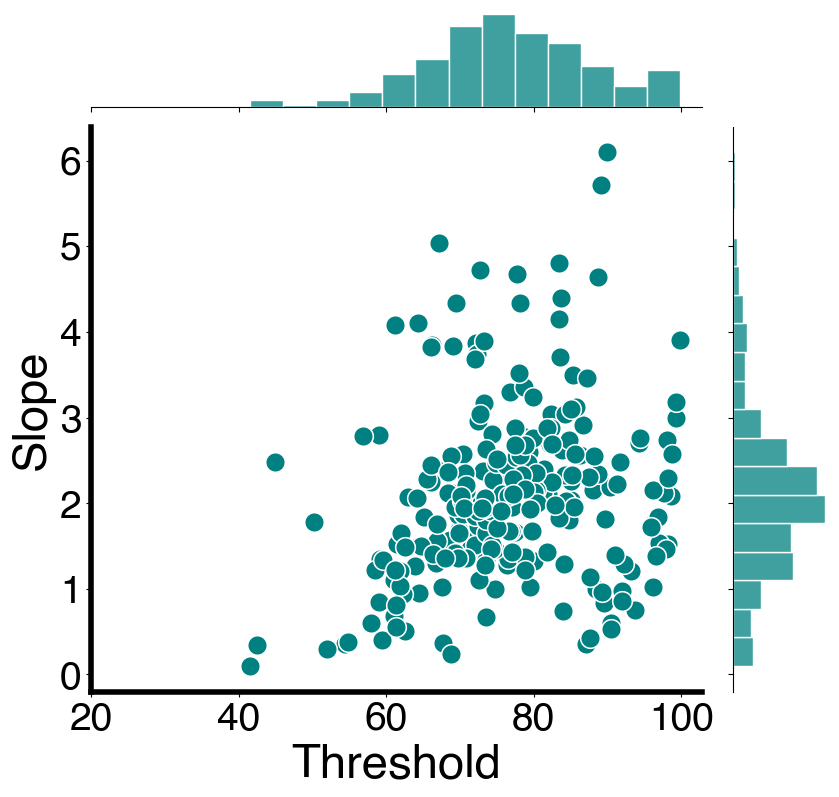

In [7]:
fig_filename = 'rrst_thresh-slope_correlation_joint.png'

# Create a DataFrame
thresh_ests = cleaned_df['psi_thresh']
slope_ests = cleaned_df['psi_slope']
df = pd.DataFrame({'Threshold': thresh_ests, 'Slope': slope_ests})

# Create the joint plot
joint_plot = sns.jointplot(x="Threshold", y="Slope", data=df, color="teal", marginal_kws={'color': 'teal', 'edgecolor': 'white'}, s=200, height=8.5)

# Access the underlying matplotlib figure and axes
fig = joint_plot.fig
ax = joint_plot.ax_joint

# Set labels and ticks
ax.set_xlabel('Threshold', fontsize=fontsize_axis_labels)
ax.set_xticks([3.4, 6.8, 10.2, 13.6, 17])  # Set the positions of the ticks
ax.set_xticklabels(['20', '40', '60', '80', '100'], fontsize=fontsize_axis_ticks)  # Set the labels for the ticks
ax.set_ylabel('Slope', fontsize=fontsize_axis_labels)
ax.tick_params(axis='both', labelsize=fontsize_axis_ticks)


# Modify spines to make the frame thicker
for spine in ax.spines.values():
    spine.set_linewidth(4)  # You can adjust the thickness (4 is just an example)

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 0.95])

if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    fig.savefig(fig_filepath, dpi=300)

plt.show()

### Fig 3c - Correlation matrix

In [8]:
# Rename columns
# Dictionary of old column names as keys and new column names as values
new_column_names = {
    'psi_thresh': 'threshold',
    'psi_slope': 'slope',
    'meanDispRating': 'unpleas',
    'meanConf': 'confBias'
}

# Rename the columns
cleaned_df.rename(columns=new_column_names, inplace=True)

# Selecting specific columns
selected_columns = ['threshold', 'slope', 'aROC', 'confBias', 'unpleas', 'gender', 'age', 'bmi']
corrplot_data = cleaned_df[selected_columns]

/var/folders/wh/fsqw487n2kz8s4zncj30yj2dk1v6zh/T/ipykernel_75780/4056491695.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.rename(columns=new_column_names, inplace=True)


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


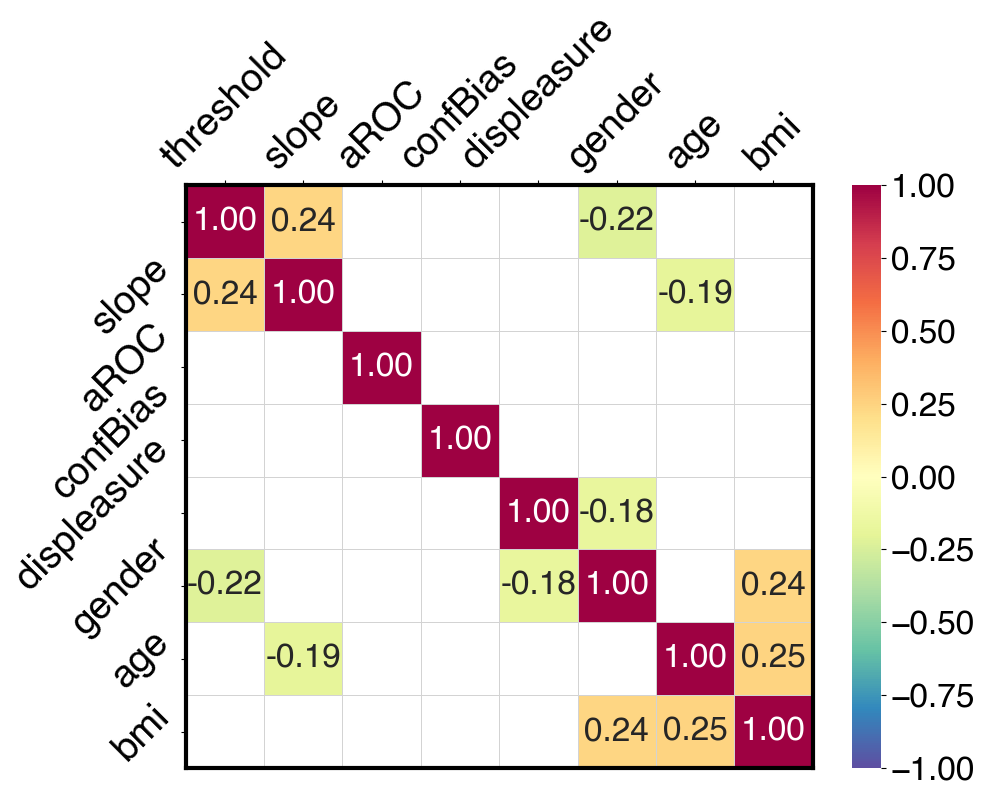

In [9]:
fig_filename = 'rrst_regressors_heatmap.png'

# Step 1: Calculate the correlation matrix and the corresponding p-value matrix
corr_matrix = corrplot_data.corr(method='spearman')
p_values = np.zeros(corr_matrix.shape)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if i != j:
            _, p = spearmanr(corrplot_data.iloc[:, i], corrplot_data.iloc[:, j])
            p_values[i, j] = p
        else:
            p_values[i, j] = np.nan

# Step 2: Flatten the matrix and apply FDR correction
flat_p_values = p_values.flatten()
flat_p_values = flat_p_values[~np.isnan(flat_p_values)]  # Remove NaN values
_, pvals_corrected, _, _ = multipletests(flat_p_values, method='fdr_bh')

# Step 3: Reconstruct the corrected p-value matrix
corrected_p_value_matrix = np.full_like(p_values, np.nan)
non_nan_indices = ~np.isnan(p_values)
corrected_p_value_matrix[non_nan_indices] = pvals_corrected

# Step 4: Apply the FDR correction to the correlation matrix
significance_level = 0.05
fdr_corrected_corr_matrix = corr_matrix.copy()
fdr_corrected_corr_matrix[corrected_p_value_matrix > significance_level] = np.nan

# create a mask to only show the lower correlation triangle
mask = np.triu(np.ones_like(fdr_corrected_corr_matrix, dtype=bool))

# Plotting the FDR Corrected Correlation Matrix
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8.5))
# Define custom colormap to reverse the colors
cmap = sns.color_palette("Spectral", as_cmap=True).reversed()
heatmap = sns.heatmap(fdr_corrected_corr_matrix, fmt=".2f", cmap=cmap, annot=True, annot_kws={"size": fontsize_axis_ticks-4}, xticklabels=True, yticklabels=True, vmin=-1, vmax=1, linewidths=0.5, linecolor='lightgrey')


# Adjust the colorbar text size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize_axis_ticks-4)  # You can adjust the font size (16 is just an example)


# Adding a border around the heatmap
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)
    spine.set_edgecolor('black')  # You can change the color here

# Move x-axis labels to the top
ax.xaxis.tick_top()

# Rotate the x and y labels if they overlap
plt.xticks(rotation=45, fontsize=fontsize_axis_ticks)  # Adjust ha='right' to move labels to the top
plt.yticks(rotation=45, fontsize=fontsize_axis_ticks)

# Remove the left-most tick label on the y-axis
yticklabels = ax.get_yticklabels()
yticklabels[0].set_visible(False)

## rotate the x and y labels if they overlap
#plt.xticks(rotation=45, fontsize=fontsize_axis_ticks)
#plt.yticks(rotation=45, fontsize=fontsize_axis_ticks)

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom margin as needed (0.95 leaves 5% space at the bottom)


if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)

plt.show()


In [9]:
# Round all values to 3 decimal digits
rounded_p_values = np.around(p_values, decimals=3)

print(rounded_p_values)

print(p_values)


[[  nan 0.    0.036 0.671 0.021 0.    0.969 0.954]
 [0.      nan 0.896 0.909 0.859 0.858 0.002 0.087]
 [0.036 0.896   nan 0.94  0.321 0.763 0.574 0.414]
 [0.671 0.909 0.94    nan 0.977 0.11  0.526 0.013]
 [0.021 0.859 0.321 0.977   nan 0.005 0.42  0.435]
 [0.    0.858 0.763 0.11  0.005   nan 0.086 0.   ]
 [0.969 0.002 0.574 0.526 0.42  0.086   nan 0.   ]
 [0.954 0.087 0.414 0.013 0.435 0.    0.      nan]]
[[           nan 1.52705532e-04 3.57094700e-02 6.71162128e-01
  2.06740305e-02 4.68266432e-04 9.68748087e-01 9.54231511e-01]
 [1.52705532e-04            nan 8.96357016e-01 9.08697608e-01
  8.59209739e-01 8.58219293e-01 2.24324977e-03 8.72062333e-02]
 [3.57094700e-02 8.96357016e-01            nan 9.39902657e-01
  3.21082423e-01 7.62560171e-01 5.73720059e-01 4.13636803e-01]
 [6.71162128e-01 9.08697608e-01 9.39902657e-01            nan
  9.77427683e-01 1.10303547e-01 5.25864855e-01 1.33495414e-02]
 [2.06740305e-02 8.59209739e-01 3.21082423e-01 9.77427683e-01
             nan 5.18834705e-

### Fig 4a -  Confidence bias histogram

In [10]:
# Increase font size for confidence plots
fontsize_axis_ticks = 30
fontsize_axis_labels = 36

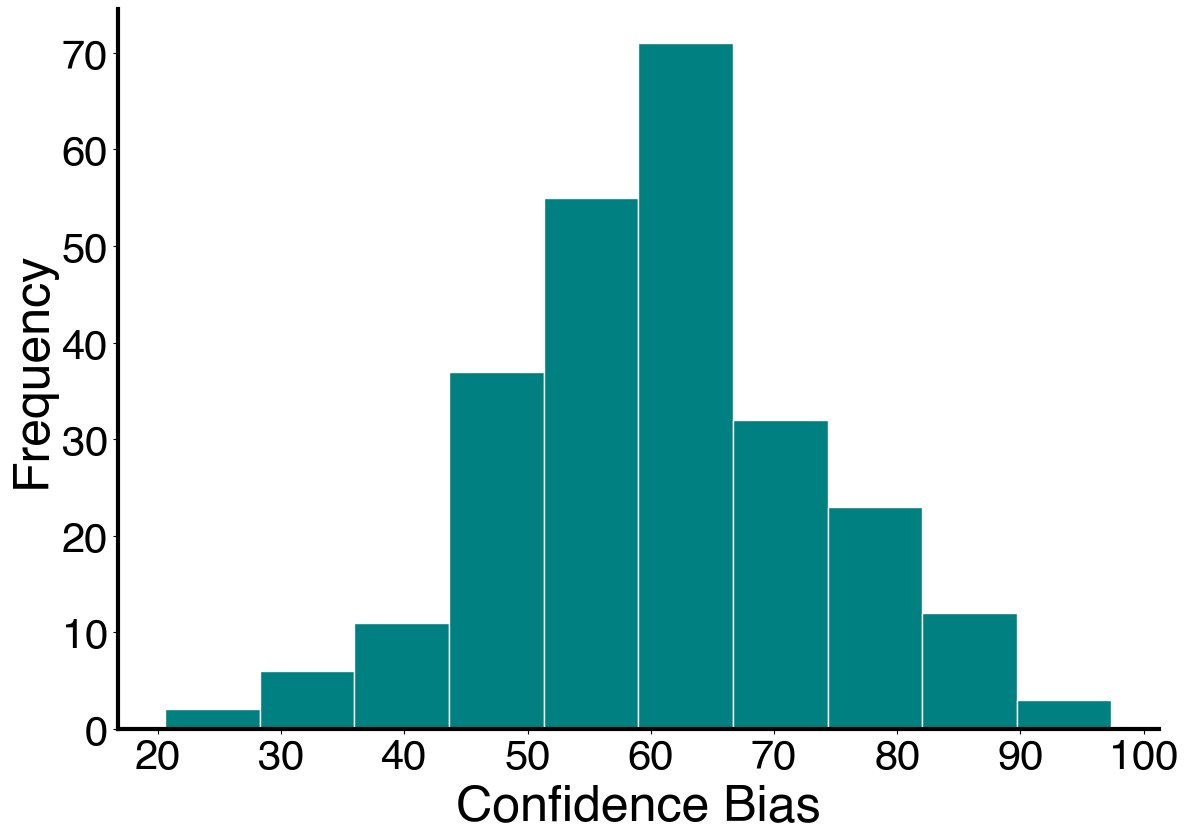

In [11]:
fig_filename = 'rrst_mean_conf_hist.png'
fig, ax = plt.subplots(figsize=(12, 8.5))

# plot a histogram
plt.hist(cleaned_df['confBias'], bins=10, color='teal', edgecolor='white')
plt.xlabel('Confidence Bias', fontsize=fontsize_axis_labels)
plt.ylabel('Frequency', fontsize=fontsize_axis_labels)
plt.xticks(fontsize=fontsize_axis_ticks)
plt.yticks(fontsize=fontsize_axis_ticks)
# Remove frame
ax = plt.gca()  # gca stands for 'get current axis'


# Increase the thickness of the axis
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3.0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the bottom margin as needed (0.95 leaves 5% space at the bottom)


if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)

plt.show()


### Fig 4d -  Accuracy & metacognition (aROC)

In [12]:
# New dataframe with data to plot
yyPlotData = cleaned_df[['id', 'psi_acc', 'aROC']]

# Sort by aROC
# To sort in ascending order
yyPlotData = yyPlotData.sort_values('aROC')
yyPlotData = yyPlotData.reset_index(drop=True)

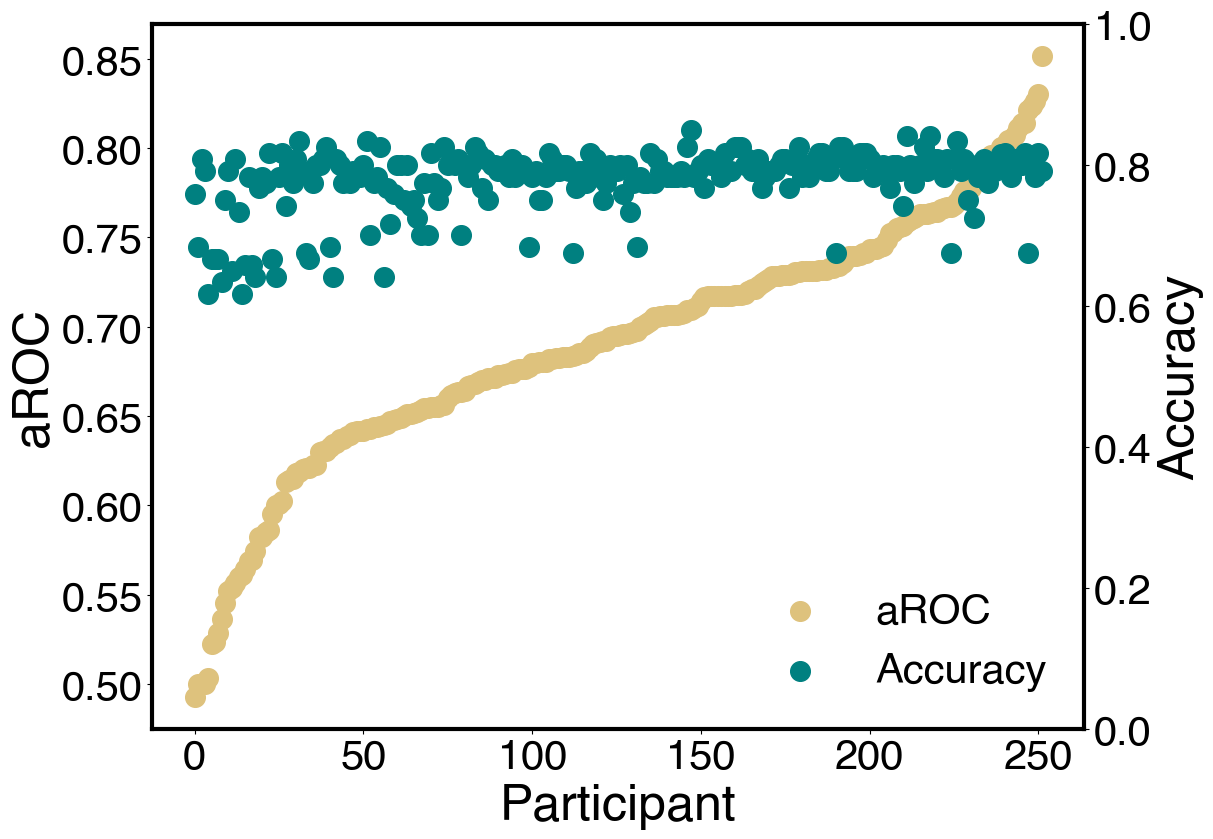

In [13]:
fig_filename = 'rrst_accuracy_aroc_y-y_plot.png'


# Assuming yyPlotData is defined
fig, ax1 = plt.subplots(figsize=(12, 8.5))
mpl.rcParams['font.family'] = 'Helvetica'

ax2 = ax1.twinx()

# Scatter plot for aROC with label
sc1 = ax1.scatter(yyPlotData.index, yyPlotData['aROC'], color=(0.87, 0.76, 0.49), edgecolor=(0.87, 0.76, 0.49), label='aROC', s = 200)
ax1.set_xlabel('Participant', fontsize=fontsize_axis_labels)
ax1.set_ylabel('aROC', fontsize=fontsize_axis_labels)
ax1.tick_params(axis='y', labelsize=fontsize_axis_ticks)
ax1.tick_params(axis='x', labelsize=fontsize_axis_ticks)

# Scatter plot for Accuracy with label
sc2 = ax2.scatter(yyPlotData.index, yyPlotData['psi_acc'], color='teal', edgecolor='teal', zorder=5, label='Accuracy', s = 200)
ax2.set_ylabel('Accuracy', fontsize=fontsize_axis_labels)
ax2.tick_params(axis='y', labelsize=fontsize_axis_ticks)
ax2.tick_params(axis='x', labelsize=fontsize_axis_ticks)
ax2.set_ylim([0, 1.0])

# Set ticks font size
plt.xticks(fontsize=fontsize_axis_ticks)
plt.yticks(fontsize=fontsize_axis_ticks)

# Increase the thickness of the axis
for axis in ['bottom', 'left', 'right', 'top']:
    ax1.spines[axis].set_linewidth(3.0)

# Display the legend
handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(handles=[sc1, sc2], labels=['aROC', 'Accuracy'], loc='lower right', fontsize=fontsize_axis_ticks)

# Remove the legend border
legend.get_frame().set_linewidth(0)

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the bottom margin as needed (0.95 leaves 5% space at the bottom)


if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)

plt.show()


### Fig 5 a - Affective ratings over session duration line plot

In [14]:
# Filter the columns
filtered_data = cleaned_df.filter(like='displeasure')
filtered_data = filtered_data.drop(filtered_data.columns[[6, 7, 8, 9]], axis=1)

# Calculate the mean and standard deviation
mean_values = filtered_data.mean()
std_values = filtered_data.std()

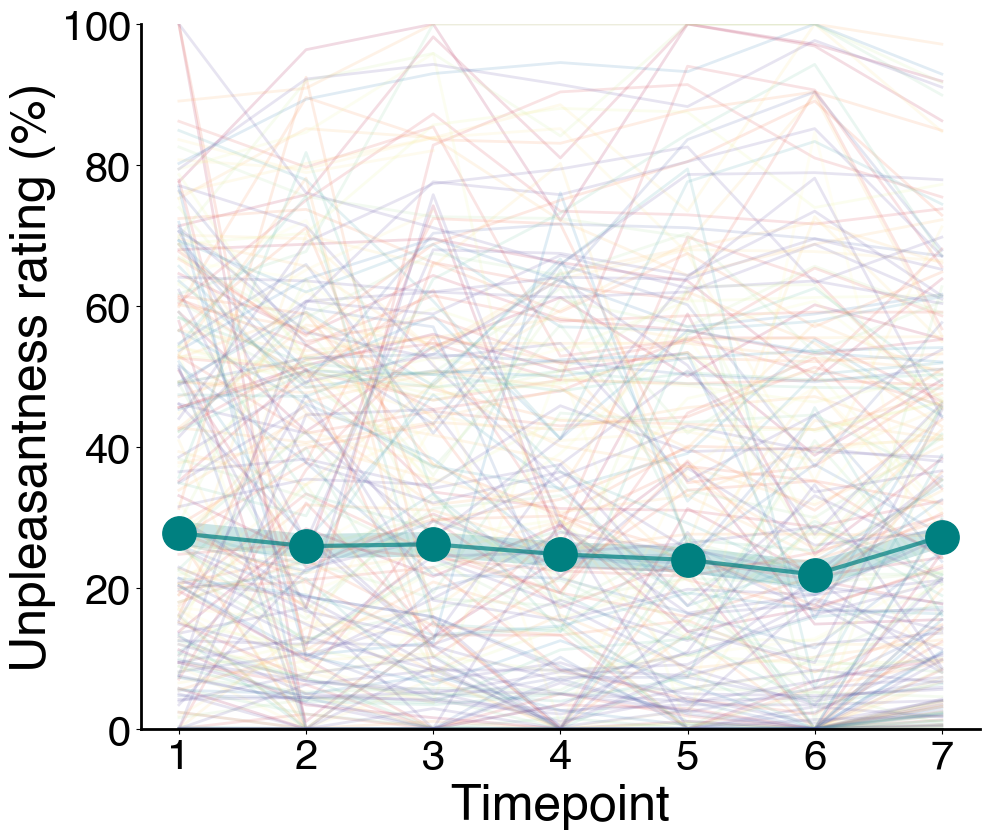

In [16]:
fig_filename = 'affective_ratings_x_timept.png'

# Create a range of x values corresponding to the column names
x = np.arange(filtered_data.shape[1])

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8.5))


# Plot each row with the 'Spectral' color map and alpha of 0.7
for index, row in filtered_data.iterrows():
    color = cm.Spectral(index / len(filtered_data))
    ax.plot(x, row, color=color, alpha=0.15, linewidth=2)

# Calculate the median and SEM
median_values = filtered_data.median()
sem_values = filtered_data.sem()

# Connect the dots with a line
ax.plot(x, median_values, linestyle='-', linewidth=3, color='teal', alpha=0.7, label='Median')

# Plot dots representing the median at each timepoint
ax.plot(x, median_values, marker='o', linestyle='none', color='teal', label='Median', markersize=24)

# Add the filled area representing SEM without an outline
ax.fill_between(x, median_values - sem_values, median_values + sem_values, color='teal', alpha=0.2, label='SEM', edgecolor='none')


# Add labels to the x-axis with the column names
ax.set_xticks(x)
# Rename the x-axis tick labels 
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'])

# Add labels
ax.set_xlabel('Timepoint', size=fontsize_axis_labels)
ax.set_ylabel('Unpleasantness rating (%)', size=fontsize_axis_labels)

# Customizing the axes
for _, spine in ax.spines.items():
    spine.set_linewidth(2)

# Removing right and top sides
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Increasing axis tick label size
ax.tick_params(axis='both', which='major', labelsize=fontsize_axis_ticks)

# Set the range of the y-axis (example: from 0 to 100)
ax.set_ylim([0, 100])

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the bottom margin as needed (0.95 leaves 5% space at the bottom)


if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)

plt.tight_layout()
plt.show()

### Supp Fig 1 c - Affective ratings box plot

In [17]:
long_df = pd.melt(cleaned_df, value_vars=['psi_breathless', 'psi_dizzy'], var_name='Measure', value_name='Rating')

print(long_df.head())

          Measure     Rating
0  psi_breathless   6.770833
1  psi_breathless   0.000000
2  psi_breathless  87.760417
3  psi_breathless   0.000000
4  psi_breathless  64.583333


/var/folders/wh/fsqw487n2kz8s4zncj30yj2dk1v6zh/T/ipykernel_71070/4279442560.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(variable_names, fontsize=fontsize_axis_labels)


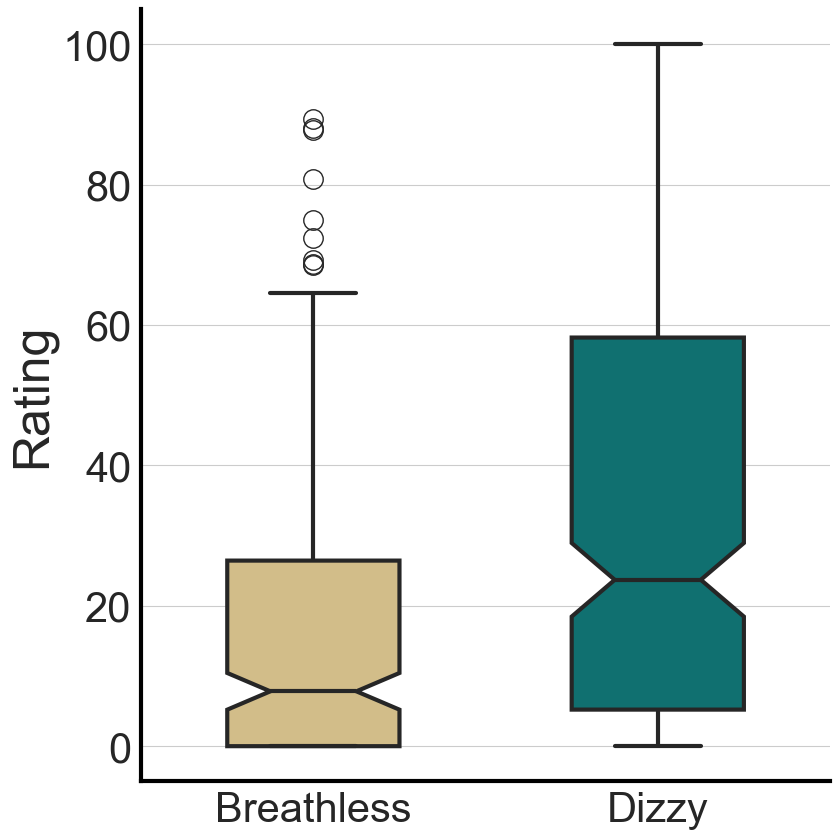

In [18]:
fig_filename = 'SuppFig1c_symptoms_ratings.png'

# Rename the variables for the x-axis labels
variable_names = ['Breathless', 'Dizzy']

# Define custom colors
custom_colors = [(0.87, 0.76, 0.49), 'teal']  # Example custom colors

# Set the style
sns.set_style("whitegrid")

# Create a box plot with Seaborn
plt.figure(figsize=(8.5, 8.5))
#ax = sns.boxplot(data=long_df, x="Measure", y="Rating", hue="Measure",
#            width=0.5, linewidth=4, notch=True, palette=custom_colors, fliersize=14)
ax = sns.boxplot(data=cleaned_df[['psi_breathless', 'psi_dizzy']], 
                 width=0.5, linewidth=3, notch=True, palette=custom_colors, fliersize=14)

# Rename the x-axis labels
ax.set_xticklabels(variable_names, fontsize=fontsize_axis_labels)

# Set labels and title
plt.ylabel('Rating', fontsize=fontsize_axis_labels)

# Set tick label size
plt.xticks(fontsize=fontsize_axis_ticks)
plt.yticks(fontsize=fontsize_axis_ticks)

# Customizing the axes
for _, spine in ax.spines.items():
    spine.set_linewidth(3)

# Customize left and bottom axes to be black
ax.spines["left"].set_color('black')
ax.spines["bottom"].set_color('black')

# Removing right and top sides
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)
    
# Show plot
plt.tight_layout()
plt.show()

# REVISION

## Add updated hierarchical model estimates to df

In [10]:
# Load the new df
updated_hier_est_path = f'{data_dir}/revision_updated_hier_est.csv'
updated_hier_est_df = pd.read_csv(updated_hier_est_path)

updated_hier_est_df['id'] = updated_hier_est_df['participant_id2'].str.extract('(\d+)').astype(int)


In [13]:
# Merge 'threshold' and 'slope' columns from 'updated_hier_est_df' with 'cleaned_df' on the 'id' column
merged_df = cleaned_df.merge(updated_hier_est_df[['id', 'threshold', 'slope']], on='id', how='left')

merged_df = merged_df.rename(columns={
    'threshold': 'updated_hier_thresh',
    'slope': 'updated_hier_slope'
})

# Add 'updated_hier_guess' and 'updated_hier_lapse' columns
merged_df['updated_hier_guess'] = 0.5
merged_df['updated_hier_lapse'] = 0.03


## Updated PMF group figure

Threshold mean 78.67707971235996 
thresh_sd 11.485489302807702 
thresh_min 46.791109147058826 
thresh_max 113.52669632352942
Slope mean:  8.50238158171131


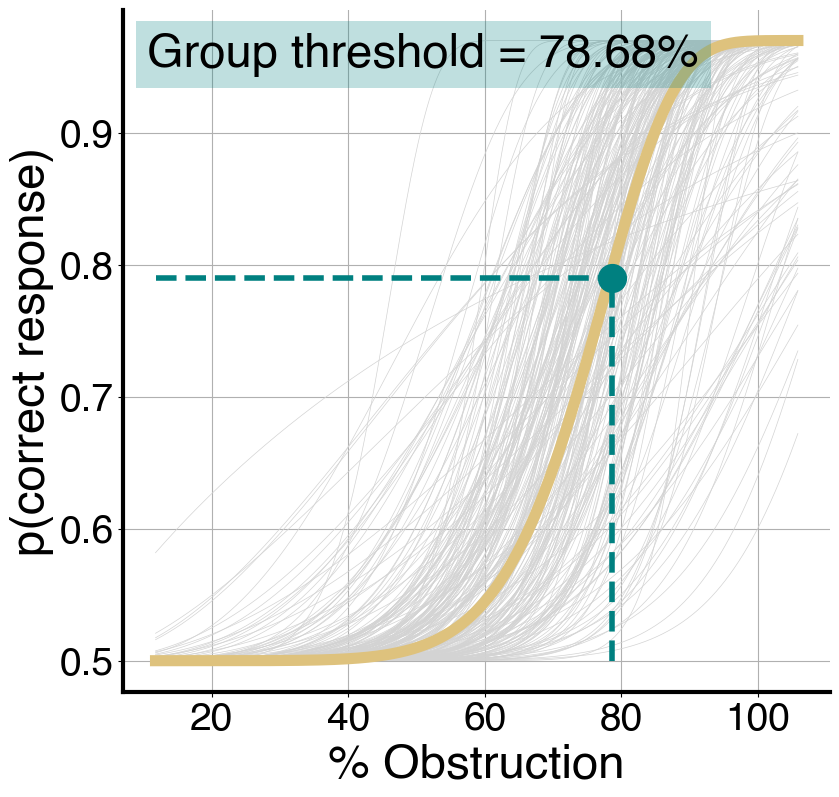

In [38]:
fig_filename = 'rrst_group_pmf_rev.png'

# Correct Weibull parametrisation
def newPsychFunc(x, threshold, slope, lower_asymptote, higher_asymptote):
    return lower_asymptote + (1 - lower_asymptote - higher_asymptote) * (1 - np.exp(-(x / threshold) ** slope))

x = np.linspace(2, 18, 1000)

# Create a square plot
plt.figure(figsize=(8.5,8.5))

# Add gridlines
plt.grid(True)
  
for index, row in merged_df.iterrows():
    intercept = row['updated_hier_thresh']
    slope = row['updated_hier_slope']
    lower_asymptote = row['updated_hier_guess']
    higher_asymptote = row['updated_hier_lapse']
    y = newPsychFunc(x, intercept, slope, lower_asymptote, higher_asymptote)
    # Draw grey functions with thinner lines
    plt.plot(x, y, color='lightgrey', linewidth=0.5)

scale_f = np.divide(100,17)
mean_intercept = merged_df['updated_hier_thresh'].mean()
mean_slope = merged_df['updated_hier_slope'].mean()
mean_lower_asymptote = merged_df['updated_hier_guess'].mean() # 0.5
mean_higher_asymptote = merged_df['updated_hier_lapse'].mean() # 0.03
thresh_mean = merged_df['updated_hier_thresh'].mean()*scale_f # scaled to % obstruction
thresh_mean_raw = merged_df['updated_hier_thresh'].mean()

thresh_sd = (np.std(merged_df['updated_hier_thresh'])) * scale_f
thresh_min = (np.min(merged_df['updated_hier_thresh'])) * scale_f
thresh_max = (np.max(merged_df['updated_hier_thresh'])) * scale_f

print('Threshold mean', thresh_mean, '\nthresh_sd', thresh_sd, '\nthresh_min', thresh_min, '\nthresh_max', thresh_max)
print('Slope mean: ', mean_slope)

y_mean = newPsychFunc(x, mean_intercept, mean_slope, mean_lower_asymptote, mean_higher_asymptote)

# Draw the mean function with a thicker yellow line
plt.plot(x, y_mean, color=(0.87, 0.76, 0.49), linewidth=8.0)

# Draw lines and point indicating mean threshold
mean_int_x = thresh_mean_raw
mean_int_y = 0.79
plt.plot([np.min(x), mean_int_x], [mean_int_y, mean_int_y], color='teal', linestyle='--', linewidth=4)
plt.plot([mean_int_x, mean_int_x], [np.min(y), mean_int_y], color='teal', linestyle='--', linewidth=4)
plt.scatter(mean_int_x, mean_int_y, s=400, color='teal', edgecolor='teal', zorder=5) # s defines the size


plt.xlabel('% Obstruction', fontsize=fontsize_axis_labels)
plt.ylabel('p(correct response)', fontsize=fontsize_axis_labels)

plt.yticks(fontsize=fontsize_axis_ticks)
plt.xticks([3.4, 6.8, 10.2, 13.6, 17], ['20', '40', '60', '80', '100'], fontsize=fontsize_axis_ticks)

# Remove frame
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Increase the thickness of the axis
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)

# Add text for thresh value
plt.text(1.8, 0.95, 'Group threshold = 78.68%', fontsize=fontsize_axis_labels, bbox={'facecolor': 'teal', 'alpha': 0.25, 'pad': 8, 'edgecolor':'none'})

# Adjust layout to prevent clipping at the bottom
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom margin as needed (0.95 leaves 5% space at the bottom)


if flag_savefigs:
    # Save the figure with a specified size and resolution
    fig_filepath = f'{figures_dir}{fig_filename}'
    plt.savefig(fig_filepath, dpi=300)


plt.show()

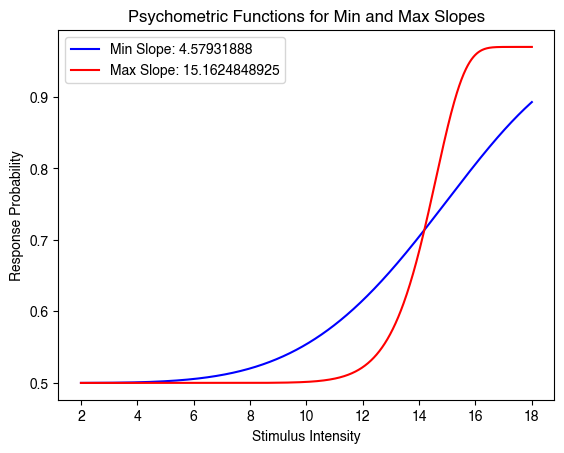

In [34]:
## Try plotting a low and high slope subject

# Find rows with the minimum and maximum values of 'updated_hier_slope'
# min_slope_row = merged_df.loc[merged_df['updated_hier_slope'].idxmin()]
# max_slope_row = merged_df.loc[merged_df['updated_hier_slope'].idxmax()]
min_slope_row = merged_df.loc[110]
max_slope_row = merged_df.loc[91]

# Generate x values (e.g., stimulus intensity levels)
x = np.linspace(2, 18, 1000)

# Plot the psychometric function for the row with the minimum slope
y_min_slope = newPsychFunc(x, min_slope_row['updated_hier_thresh'], min_slope_row['updated_hier_slope'], 0.5, 0.03)
plt.plot(x, y_min_slope, label=f'Min Slope: {min_slope_row["updated_hier_slope"]}', color='blue')

# Plot the psychometric function for the row with the maximum slope
y_max_slope = newPsychFunc(x, max_slope_row['updated_hier_thresh'], max_slope_row['updated_hier_slope'], 0.5, 0.03)
plt.plot(x, y_max_slope, label=f'Max Slope: {max_slope_row["updated_hier_slope"]}', color='red')

# Add labels and legend
plt.xlabel('Stimulus Intensity')
plt.ylabel('Response Probability')
plt.title('Psychometric Functions for Min and Max Slopes')
plt.legend()

# Show the plot
plt.show()

In [7]:
# Calculate Spearman correlation between threshold and accuracy
# Assuming cleaned_df is your dataframe containing 'psi_thresh' and 'psi_acc' columns
spearman_corr, p_value = spearmanr(cleaned_df['psi_thresh'], cleaned_df['psi_acc'])
print(f"Accuracy - threshold")
print(f"Spearman Correlation: {spearman_corr}")
print(f"P-value: {p_value}")

spearman_corr, p_value = spearmanr(cleaned_df['meanConf'], cleaned_df['psi_acc'])
print(f"Accuracy - confidence bias")
print(f"Spearman Correlation: {spearman_corr}")
print(f"P-value: {p_value}")

spearman_corr, p_value = spearmanr(cleaned_df['aROC'], cleaned_df['psi_acc'])
print(f"Accuracy - aROC")
print(f"Spearman Correlation: {spearman_corr}")
print(f"P-value: {p_value}")

Accuracy - threshold
Spearman Correlation: -0.6530316402336364
P-value: 5.089715185268146e-32
Accuracy - confidence bias
Spearman Correlation: -0.0016161318243703604
P-value: 0.9796340031924329
Accuracy - aROC
Spearman Correlation: 0.35398074347305697
P-value: 7.490336520593819e-09


In [8]:
# Cleaned DF
slope_mean = cleaned_df['psi_slope'].mean()
slope_sd = (np.std(cleaned_df['psi_slope']))
slope_min = (np.min(cleaned_df['psi_slope']))
slope_max = (np.max(cleaned_df['psi_slope']))

print('Slope mean: ', slope_mean, '\nSlope s.d.: ', slope_sd, '\nSlope min: ', slope_min, '\nSlope max:', slope_max)

Slope mean:  2.091464707205178 
Slope s.d.:  0.9927285207395112 
Slope min:  0.0951800609949348 
Slope max: 6.1012301685472


In [9]:
# VBQ subset
slope_mean = rrst_data_subset['psi_slope'].mean()
slope_sd = (np.std(rrst_data_subset['psi_slope']))
slope_min = (np.min(rrst_data_subset['psi_slope']))
slope_max = (np.max(rrst_data_subset['psi_slope']))

print('Slope mean: ', slope_mean, '\nSlope s.d.: ', slope_sd, '\nSlope min: ', slope_min, '\nSlope max:', slope_max)

Slope mean:  2.125842995169082 
Slope s.d.:  1.0355758970670368 
Slope min:  0.0952 
Slope max: 6.1012
